# Deep Q Network로의 여행.
# Part II. Experience replay

![좋은 그림](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg)

[읽어보면 좋은 것 1](https://arxiv.org/pdf/1312.5602.pdf)<br>
[읽어보면 좋은 것 2](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)



# 라이브러리 설치 / 불러오기

In [12]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
CPU times: user 56 ms, sys: 44.4 ms, total: 100 ms
Wall time: 11 s


In [13]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [14]:
display = Display(visible=0, size=(1400, 900))
display.start()

비디오 녹화용 함수

In [15]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# CartPole

[CartPole 링크](https://gym.openai.com/envs/CartPole-v1/)
<br>
<img src='https://inspaceai.github.io/images/lhh/cartpole_rl_compare/cartpole.gif'>

In [16]:
env = wrap_env(gym.make("CartPole-v1"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
steps:  15


# Deep Neural Network for Q-function

**Q-function기능을 할 뉴럴넷을 구성할 것이다.**
1. input은 state다. (노드 수는?)
2. output은 그 state에서 취할 수 있는 action에 대한 Q값이다. (노드 수는?)

![좋은그림](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2019/11/20/Fig2-DeepRL-SageMaker.gif)

### State와 Action 정의
* Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
* Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

In [17]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (4,)
action 수는? :  2


**다음과 같이 구성하시오.**
1. Q값에 대한 회귀 문제이다! (아웃풋레이어의 activation은?)
2. 히든레이어는 2개를 구성한다.(각각 노드32, 24)
3. 컴파일 까지!
4. **Functional**하게!  (너무 힘들면 Sequential하게)

In [18]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [19]:
### 이것은 일단 그냥 사용해보자!
### huber 로스!
from tensorflow.keras.losses import Huber
def mean_huber_loss(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(Huber(clip_delta)(y_true, y_pred))

In [20]:
keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=[ env.observation_space.shape[0] ]) #  env.observation_space.shape[0] --> 8
Hidden_layer = Dense(64, activation='swish')(state_layer)
Hidden_layer = Dense(64, activation='swish')(Hidden_layer)
q_layer = Dense(env.action_space.n, activation='softmax')(Hidden_layer)  # env.action_space.n --> 4

Q_network = Model(state_layer, q_layer)

Q_network.compile(loss = mean_huber_loss,
              optimizer = Adam())

Q_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


# Memory 구현 & Memory에 어느정도 Experience를 담아두기!

1. (s0, a0, r1, s1, done)을 담아두면 된다. 튜플!
2. deque를 이용하여 최근 만개의 Experience만 담아둘수 있도록 한다.
3. Experience 를 replay하며 배울 때는..
    * sample_size = bach_size = 128 개씩 경험을 랜덤추출하여 .fit()할 것이다!
    * 따라서 experience(s0, a0, r1, s1, done)은 충분히 미리 담아두자.
    * 랜덤액션으로 담아두어도 좋다.

In [21]:
from collections import deque
memory = deque(maxlen = 10000)  # 리스트 처럼 사용이 가능하다.

In [22]:
alpha = 0.1
gamma = 0.95
n_episod = 100
epsilon = 0.1
pre_play = 100 # 실제 담기는건 10개가 아닐 것!

for i in range(pre_play) :
    print(i, " 번째 에피소드,")
    s0 = env.reset()
    s0 = s0.reshape([1, -1]) # 2차원 어레이로 바꿔주기
    done = False

    while True :

        a0 = env.action_space.sample()   # 랜덤 액션!
        # a0 를 이용하여 s1, r1, done, _ 선언
        s1, r1, done, _ = env.step(a0)
        
        s1 = s1.reshape([1,-1]) # 2차원 어레이로 바꿔주기

        if done == False :
            memory.append( (s0, a0, r1, s1, done) )
            s0 = s1
        else :
            s1 = np.zeros(s0.shape)  # 끝나면 s1가 0이 됨!
            memory.append( (s0, a0, r1, s1, done) )
            env.close()
            break
    print("저장된 experience : {}".format(len(memory)))

0  번째 에피소드,
저장된 experience : 46
1  번째 에피소드,
저장된 experience : 90
2  번째 에피소드,
저장된 experience : 100
3  번째 에피소드,
저장된 experience : 114
4  번째 에피소드,
저장된 experience : 129
5  번째 에피소드,
저장된 experience : 152
6  번째 에피소드,
저장된 experience : 164
7  번째 에피소드,
저장된 experience : 190
8  번째 에피소드,
저장된 experience : 203
9  번째 에피소드,
저장된 experience : 224
10  번째 에피소드,
저장된 experience : 236
11  번째 에피소드,
저장된 experience : 266
12  번째 에피소드,
저장된 experience : 328
13  번째 에피소드,
저장된 experience : 360
14  번째 에피소드,
저장된 experience : 388
15  번째 에피소드,
저장된 experience : 400
16  번째 에피소드,
저장된 experience : 414
17  번째 에피소드,
저장된 experience : 452
18  번째 에피소드,
저장된 experience : 465
19  번째 에피소드,
저장된 experience : 542
20  번째 에피소드,
저장된 experience : 561
21  번째 에피소드,
저장된 experience : 581
22  번째 에피소드,
저장된 experience : 601
23  번째 에피소드,
저장된 experience : 614
24  번째 에피소드,
저장된 experience : 628
25  번째 에피소드,
저장된 experience : 654
26  번째 에피소드,
저장된 experience : 679
27  번째 에피소드,
저장된 experience : 713
28  번째 에피소드,
저장된 experience : 729
29  번째 에피소드,
저장된 experienc

In [23]:
print(f'리스트 메모리 길이 : {len(memory)}')
print(f'* 메모리 내용 1개 보기')
print(f'  - 메모리 첫번째(리스크 첫번째) : s0(4), a0(0~1중 max), r1(int), s1(4), done(boolean) 구성')
print(f'  - s0 : {memory[0][0]}')
print(f'  - a0 : {memory[0][1]}')
print(f'  - r1 : {memory[0][2]}')
print(f'  - s1 : {memory[0][3]}')
print(f'  - done : {memory[0][4]}')

리스트 메모리 길이 : 2389
* 메모리 내용 1개 보기
  - 메모리 첫번째(리스크 첫번째) : s0(4), a0(0~1중 max), r1(int), s1(4), done(boolean) 구성
  - s0 : [[-0.03565692 -0.0384332   0.00569418  0.02283113]]
  - a0 : 0
  - r1 : 1.0
  - s1 : [[-0.03642558 -0.23363635  0.00615081  0.31730518]]
  - done : False


# Memory로 부터 배치 사이즈 만큼 데이터를 떼어 오는 함수 제작

* .fit(s0, target_Q) 임을 고려하자

In [24]:
import random
def create_batch(model, memory, gamma, batch_size = 128):
    sample = np.array(random.sample(memory, batch_size))

    s0 = sample[:, 0]
    a0 = sample[:, 1].astype(np.int8)
    r1 = sample[:, 2]
    s1 = sample[:, 3]
    d = sample[:, 4]

    s0_batch = np.vstack(s0)
    s1_batch = np.vstack(s1)
    target_Q_batch = model.predict(s0_batch)
    Q_s1 = model.predict(s1_batch)
    ###### Q-table에서 업데이트는 ? #############################################
    ## Q[s0, a0] = Q[s0, a0] + alpha * (r1 + gamma*np.max(Q[s1,:]) - Q[s0, a0]) #
    #############################################################################

    target_Q_batch[np.arange(batch_size),a0] = r1 + gamma*np.max(Q_s1, axis=1)*(1-d)

    return s0_batch, target_Q_batch

# Memory로 부터 학습 하는 Q-Network!

episode 1 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 2 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 2  ============
최종누적보상 : 10.0
0 [[0.5535341  0.44646585]]


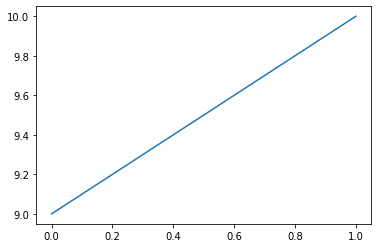

episode 3 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 4 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 4  ============
최종누적보상 : 15.0
0 [[0.6493003  0.35069975]]


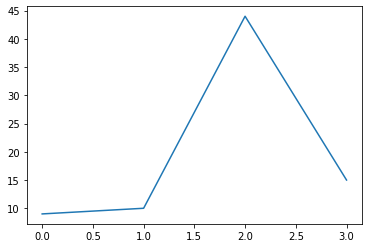

episode 5 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 6 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 6  ============
최종누적보상 : 12.0
0 [[0.68035114 0.31964886]]


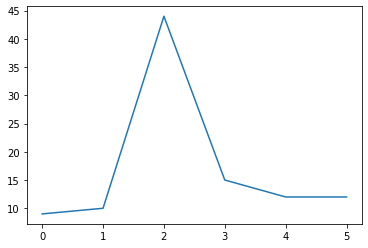

episode 7 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 8 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 8  ============
최종누적보상 : 8.0
0 [[0.7745556  0.22544438]]


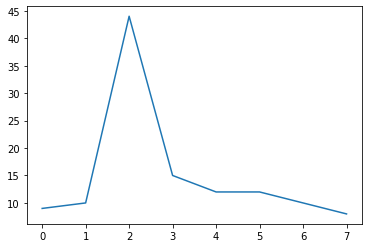

episode 9 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 10 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 10  ============
최종누적보상 : 12.0
0 [[0.8278207  0.17217922]]


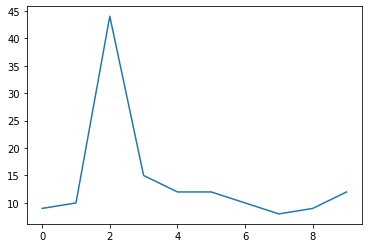

episode 11 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 12 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 12  ============
최종누적보상 : 9.0
0 [[0.9105912  0.08940882]]


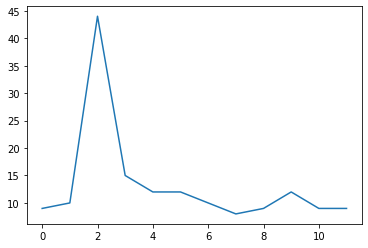

episode 13 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 14 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 14  ============
최종누적보상 : 9.0
0 [[0.9644983  0.03550171]]


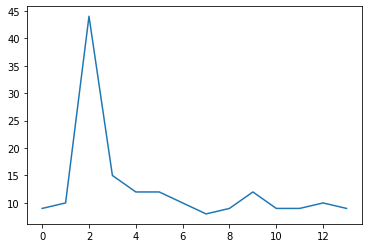

episode 15 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 16 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 16  ============
최종누적보상 : 11.0
0 [[0.990388   0.00961205]]


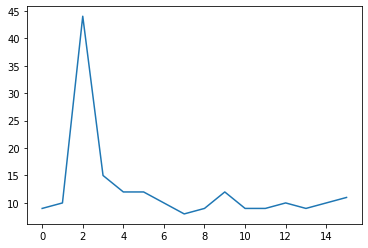

episode 17 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 18 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 18  ============
최종누적보상 : 9.0
0 [[0.99867356 0.0013265 ]]


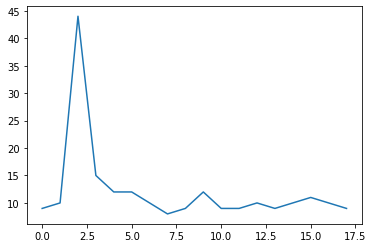

episode 19 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 20 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 20  ============
최종누적보상 : 9.0
0 [[0.9984958  0.00150418]]


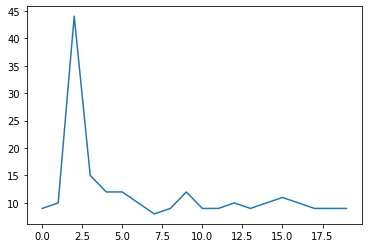

episode 21 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 22 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 22  ============
최종누적보상 : 9.0
0 [[0.9984401  0.00155986]]


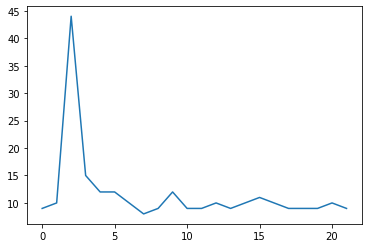

episode 23 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 24 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 24  ============
최종누적보상 : 9.0
0 [[0.99893814 0.00106189]]


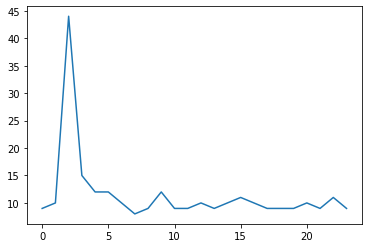

episode 25 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 26 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 26  ============
최종누적보상 : 9.0
0 [[9.9979812e-01 2.0191891e-04]]


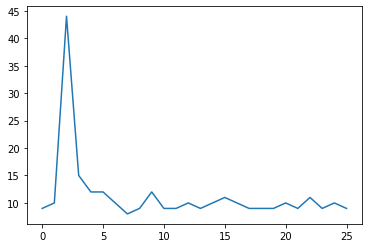

episode 27 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 28 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 28  ============
최종누적보상 : 9.0
0 [[9.9967754e-01 3.2244509e-04]]


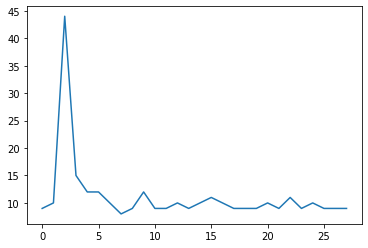

episode 29 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 30 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 30  ============
최종누적보상 : 11.0
0 [[9.9998629e-01 1.3657421e-05]]


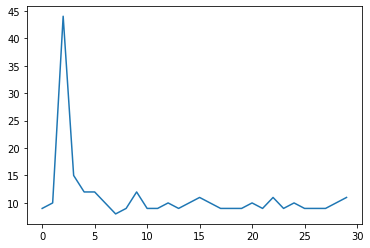

episode 31 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 32 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 32  ============
최종누적보상 : 9.0
0 [[0.99881965 0.0011803 ]]


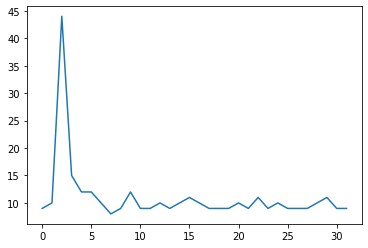

episode 33 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 34 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 34  ============
최종누적보상 : 11.0
0 [[9.9956721e-01 4.3275458e-04]]


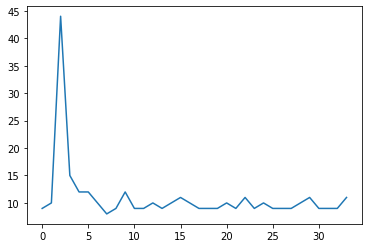

episode 35 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 36 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 36  ============
최종누적보상 : 9.0
0 [[9.9935883e-01 6.4117130e-04]]


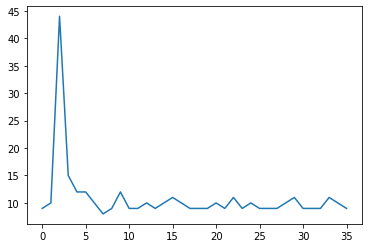

episode 37 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 38 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 38  ============
최종누적보상 : 10.0
0 [[9.9994552e-01 5.4466556e-05]]


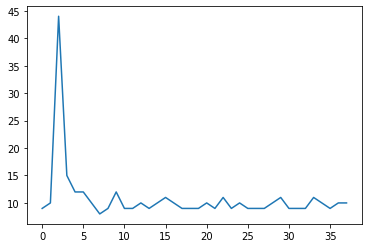

episode 39 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 40 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 40  ============
최종누적보상 : 11.0
0 [[9.9996316e-01 3.6888323e-05]]


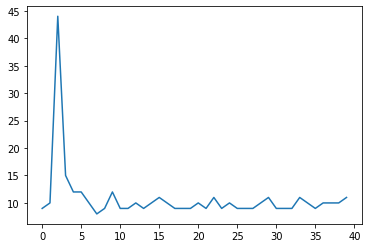

episode 41 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 42 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 42  ============
최종누적보상 : 10.0
0 [[9.9999642e-01 3.6292267e-06]]


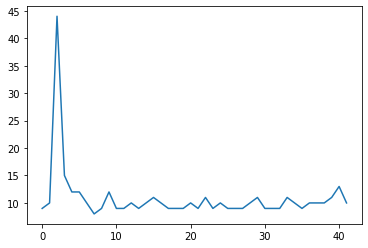

episode 43 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 44 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 44  ============
최종누적보상 : 10.0
0 [[9.9999690e-01 3.0835015e-06]]


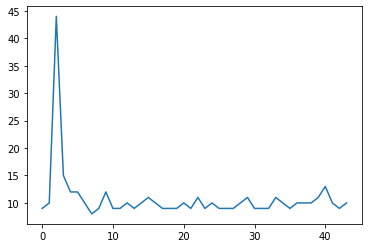

episode 45 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 46 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 46  ============
최종누적보상 : 10.0
0 [[9.9996305e-01 3.6982121e-05]]


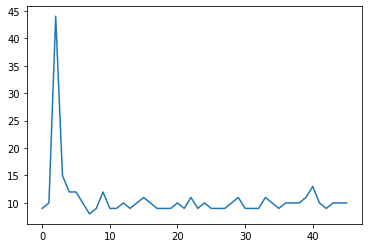

episode 47 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 48 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 48  ============
최종누적보상 : 9.0
0 [[9.9990916e-01 9.0853413e-05]]


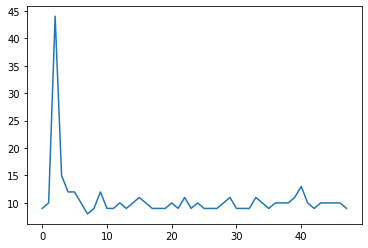

episode 49 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 50 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 50  ============
최종누적보상 : 10.0
0 [[9.9999928e-01 7.6655186e-07]]


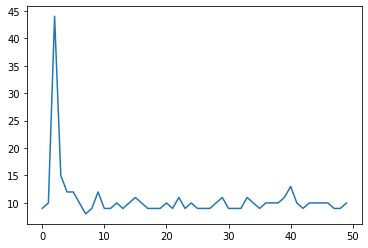

episode 51 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 52 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [25]:
env.close()

alpha = 0.1
gamma = 0.9
n_episod = 200
epsilon = 0.1
sample_size = batch_size = 128
cum_rewards = []

for i in range(n_episod) :
    print("episode {} --진행 중".format(i+1))
    env = wrap_env(gym.make("CartPole-v1"))
    s0 = env.reset()
    s0 = s0.reshape([1, -1]) # 2차원 어레이로 바꿔주기
    done = False

    cum_r = 0

    while True :
        Q_s0 = Q_network.predict(s0) #s0에서의 action들의 Q_value
        # a0 행동 선택하기 e-greedy 방법
        if np.random.uniform() < epsilon :
            a0 = env.action_space.sample()
        else : 
            a0 = np.argmax(Q_s0)

        # a0로 환경과 상호작용하여, s1,r1,done,_
        s1, r1, done, _ = env.step(a0)
        s1 = s1.reshape([1,-1]) # 2차원 어레이로 바꿔주기   

        # 메모리에 저장!
        memory.append((s0, a0, r1, s1, done))

        # 학습을 위해 Experience Replay!

        s0_batch, target_Q_batch = create_batch(Q_network, memory, gamma, batch_size=batch_size)
        Q_network.fit(s0_batch, target_Q_batch, epochs=1, verbose=0, batch_size=batch_size)
        cum_r = cum_r + r1
        if done == True : # 종료 되었다면
            cum_rewards.append(cum_r)
            env.close() # 환경닫고
            break # 멈추자.

        s0 = s1 # 다음 루프에선 이것이 직전 state

    if (i+1) % 2 == 0 :
            print('===========  에피소드 : {}  ============'.format(i+1))
            print('최종누적보상 :',cum_r)
            print(a0, Q_s0)
            plt.plot(cum_rewards)
            plt.show()
            show_video()
        